In [1]:
using PyPlot, Interact

# Fitting a nonlinear-resistance model

In the previous lecture, we solved a circuit problem where the resistance $R$ ($=1/Y$ where $Y$ is admittance) was nonlinear in the voltage difference $d$:

$$
R = x_1 + x_2 d^2 .
$$

One would normally get these coefficients $x_1$ and $x_2$ by experimental measurements.  Such "fitting" processes lead directly into the next major topic in 18.06:

## Exact fits

Suppose we put two voltage differences $d_1$ and $d_2$ across our resistor, and measure two resistances $R_1$ and $R_2$.  This leads to the following $2 \times 2$ system of equations for the unknown coefficients $x_1$ and $x_2$:

$$
\begin{pmatrix} x_1 + x_2 d_1^2 \\ x_1 + x_2 d_2^2 \end{pmatrix} =
\underbrace{\begin{pmatrix} 1 & d_1^2 \\ 1 & d_2^2 \end{pmatrix}}_A
\underbrace{\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}}_x =
\underbrace{\begin{pmatrix} R_1 \\ R_2 \end{pmatrix}}_b \; ,
$$

i.e. a system $Ax = b$.   As long as $|d_1| \ne |d_2|$, the matrix $A$ is non-singular, and this has a unique solution: an **interpolating polynomial** going through the two data points:

Interact.Options{:SelectionSlider,Float64}(1: "input" = 0.5 Float64 , "d₁", 0.5, "0.5", Interact.OptionDict(DataStructures.OrderedDict("0.0"=>0.0,"0.1"=>0.1,"0.2"=>0.2,"0.3"=>0.3,"0.4"=>0.4,"0.5"=>0.5,"0.6"=>0.6,"0.7"=>0.7,"0.8"=>0.8,"0.9"=>0.9…), Dict(0.6=>"0.6",0.3=>"0.3",0.7=>"0.7",0.0=>"0.0",0.2=>"0.2",0.9=>"0.9",0.8=>"0.8",0.5=>"0.5",0.1=>"0.1",0.4=>"0.4"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(3: "input-2" = 1.5 Float64 , "d₂", 1.5, "1.5", Interact.OptionDict(DataStructures.OrderedDict("1.1"=>1.1,"1.2"=>1.2,"1.3"=>1.3,"1.4"=>1.4,"1.5"=>1.5,"1.6"=>1.6,"1.7"=>1.7,"1.8"=>1.8,"1.9"=>1.9,"2.0"=>2.0…), Dict(1.2=>"1.2",1.1=>"1.1",2.0=>"2.0",1.3=>"1.3",1.5=>"1.5",1.6=>"1.6",1.8=>"1.8",1.9=>"1.9",1.7=>"1.7",1.4=>"1.4"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(5: "input-3" = 1.5 Float64 , "R₁", 1.5, "1.5", Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"1.1"=>1.1,"1.2"=>1.2,"1.3"=>1.3,"1.4"=>1.4,"1.5"=>1.5,"1.6"=>1.6,"1.7"=>1.7,"1.8"=>1.8,"1.9"=>1.9…), Dict(1.2=>"1.2",2.0=>"2.0",1.5=>"1.5",1.4=>"1.4",1.6=>"1.6",1.9=>"1.9",1.1=>"1.1",1.3=>"1.3",1.8=>"1.8",1.7=>"1.7"…)), Any[], Any[], true, "horizontal")

Interact.Options{:SelectionSlider,Float64}(7: "input-4" = 1.5 Float64 , "R₂", 1.5, "1.5", Interact.OptionDict(DataStructures.OrderedDict("1.0"=>1.0,"1.1"=>1.1,"1.2"=>1.2,"1.3"=>1.3,"1.4"=>1.4,"1.5"=>1.5,"1.6"=>1.6,"1.7"=>1.7,"1.8"=>1.8,"1.9"=>1.9…), Dict(1.2=>"1.2",2.0=>"2.0",1.5=>"1.5",1.4=>"1.4",1.6=>"1.6",1.9=>"1.9",1.1=>"1.1",1.3=>"1.3",1.8=>"1.8",1.7=>"1.7"…)), Any[], Any[], true, "horizontal")

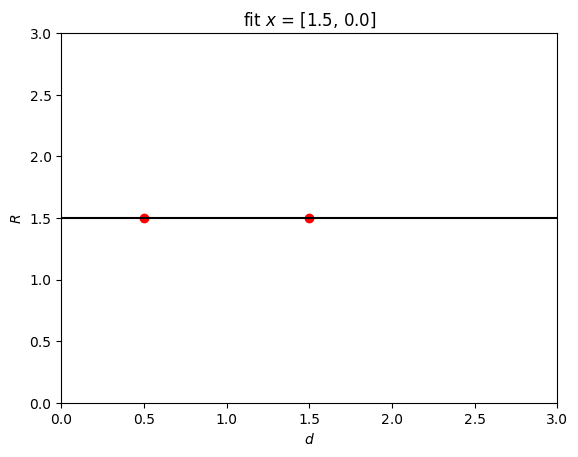

In [2]:
let fig = figure(), d = linspace(0,3,100)
    @manipulate for d₁=0:0.1:1, d₂=1.1:0.1:2, R₁=1:0.1:2, R₂=1:0.1:2
        withfig(fig) do
            x = [1 d₁^2; 1 d₂^2] \ [R₁, R₂]
            plot([d₁, d₂], [R₁, R₂], "ro")
            plot(d, x[1] + x[2]*d.^2, "k-")
            xlim(0,3)
            ylim(0,3)
            title("fit \$x\$ = $x")
            xlabel(L"d")
            ylabel(L"R")
        end
    end
end

In general, if you have $m$ points you can interpolate them in this way by a degree $m-1$ polynomial (called the [Lagrange interpolating polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial)) in this way: you set up an $m \times m$ matrix system for the coefficients.

Note, however, that this is neither the most efficient nor the most accurate (given roundoff errors) method to compute an exact interpolating polynomial.  There is a much better method called [barycentric interpolation](https://people.maths.ox.ac.uk/trefethen/barycentric.pdf) that is outside the scope of 18.06.

## Inexact fits

Suppose we do more than just the bare minimum number of measurements, however.  Suppose that we do $m > 2$ measurements.  This gives the following system of equations:



$$
\underbrace{\begin{pmatrix} 1 & d_1^2 \\ 1 & d_2^2 \\
                           \vdots & \vdots  \\ 1 & d_m^2 \end{pmatrix}}_A
\underbrace{\begin{pmatrix} x_1 \\ x_2 \end{pmatrix}}_x =
\underbrace{\begin{pmatrix} R_1 \\ R_2 \\ \vdots \\ R_m \end{pmatrix}}_b \; ,
$$

Now, $A$ is $m \times 2$, and full column rank (assuming distinct voltages $|d_k|$), but of course it is not invertible for $m > 2$.

It will still have a solution (a unique solution!) if all of the $R_k$ measurements fall *exactly* on a quadratic curve $x_1 + x_2 d^2$, but in a real experiment there would be some *measurement noise* that would spoil this.

For example, let's suppose $x = (1,2)$ and we do $m=200$ measurements for $d \in [0,2]$, but that each measurement has a random uncertainty $\approx R \pm 0.1$.

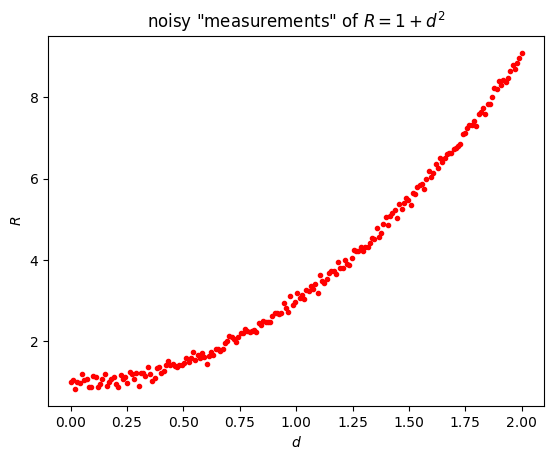

PyObject <matplotlib.text.Text object at 0x11de5cc50>

In [3]:
d = linspace(0,2,200) # 20 points from 1 to 4
b = 1 + 2*d.^2 + randn(200)*0.1 # measurements with Gaussian random noise
plot(d, b, "r.")
xlabel(L"d")
ylabel(L"R")
title("noisy \"measurements\" of \$R = 1 + d^2\$")

The corresponding matrix $A$ is:

In [4]:
A = [ones(d) d.^2]
rank(A)

2

$A$ doesn't have an inverse, of course:

In [5]:
inv(A)

LoadError: [91mDimensionMismatch("matrix is not square: dimensions are (200, 2)")[39m

However, if we blindly do `A \ b`, it seems to give us quite a reasonable $x$, very close to the exact $x = (1,2)$ of the underlying data:

In [6]:
x̂ = A \ b

2-element Array{Float64,1}:
 0.977037
 2.00736 

What is it doing?  Let's plot the curve from the coefficients `A \ b`:

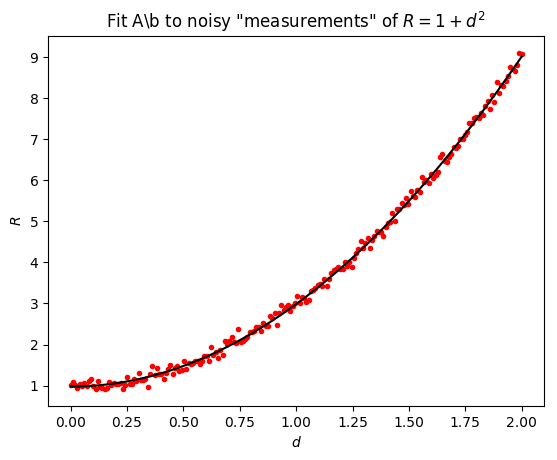

PyObject <matplotlib.text.Text object at 0x11df15110>

In [7]:
d = linspace(0,2,200) # 20 points from 1 to 4
b = 1 + 2*d.^2 + randn(200)*0.1 # measurements with Gaussian random noise
plot(d, b, "r.")
plot(d, x̂[1] + x̂[2] * d.^2, "k-")
xlabel(L"d")
ylabel(L"R")
title("Fit A\\b to noisy \"measurements\" of \$R = 1 + d^2\$")

In [8]:
norm(b - A*x̂)  # the length of the "residual" b - Ax̂ is not zero!

1.3991343723687082

This $\hat{x}$ is *not* an exact solution: $A\hat{x} \ne b$: the "residual" (the "error") $b - A\hat{x}$ is not zero, as we can see by checking its norm $\Vert b - A\hat{x}\Vert$ above.

In the plot above, correspondingly, the black "fit" curve does *not* exactly match the data points.  But it is pretty close!

# Least-square fits

What `A \ b` is doing in Julia, for a non-square "tall" matrix $A$ as above, is computing a **least-square fit** that **minimizes the sum of the square of the errors**.   This is an extremely important thing to do in many areas of linear algebra, statistics, engineering, science, finance, etcetera.

Above, we have a bunch of measurements $(d_k, R_k)$, and we are trying to *fit* it to a function $R(x,d) = x_1 + x_2 d^2$.   There is no exact fit, so instead we minimize the sum of the squares of the errors:

$$
\min_{x \in \mathbb{R}^2} \sum_{k=1}^m (R_k - R(x, d_k))^2 \;.
$$

Let's write this in terms of linear-algebra operations.  We have our $m \times 2$ matrix $A$ above, and in terms of this we have $R(x, d_k) = (Ax)_k$: the "fit" function at $d_k$ is the $k$-th row of $Ax$.  But then $R_k - R(x,d_k)$ is the $k$-th row of the **residual vector**

$$
\mbox{residual} = b - Ax
$$

and we can see that our sum above is precisely the **sum of the squares of the residual components**, which is the **square of the length of the residual**:

$$
\sum_{k=1}^m (R_k - R(x, d_k))^2 = \Vert b - Ax \Vert^2 \; .
$$

Here, $\Vert y \Vert = \sqrt{y^T y}$ is the *length* of a vector, also called the **norm of the vector**: the square root of the dot product with itself.  (More specifically, this is the [Euclidean norm](https://en.wikipedia.org/wiki/Euclidean_distance), also called the $L^2$ norm.  There are other ways to define a vector norm, but I think this is the only one we will use in 18.06.)

So, what we are *really* doing is **minimizing the norm of the residual**:

$$
\boxed{
\min_{x \in \mathbb{R}^2} \Vert b - Ax \Vert
}
$$

(Note that minimizing the norm and minimizing the squared norm will give the same solution $x$; which one we write is a matter of convenience.)

This is exactly what `A \ x` does in Julia (and Matlab) for a non-square matrix $A$, which is why it gives us a good fit above.

## Least-squares fits and the normal equations

As derived in section 4.3 of the Strang textbook, minimizing $\Vert b - Ax\Vert$ or (equivalently) $\Vert b - Ax\Vert^2$ leads to the so-called **"normal equations"** for the minimizer $\hat{x}$:

$$
\boxed{ A^T A \hat{x} = A^T b }
$$

These *always* have a solution.  If $A$ is an $m \times n$ matrix, then $A^T A$ is $n \times n$, and:

* Usually in fitting problems, $A$ is a "tall" matrix with full column rank $n$, in which case $\operatorname{rank}(A^T A) = \operatorname{rank}(A) = n$ and $A^T A$ is *invertible*: the solution $\hat{x}$ exists and is unique.

* Even if $\operatorname{rank}(A) < n$, we still have a (non-unique) solution, because $A^T b \in C(A^T) = N(A)^\perp = N(A^T A)^\perp = C(A^T A)$.

Now (on the blackboard), I will show that we can derive the normal equations directly by 18.02.  If we just take the partial derivatives of $f(x) = \Vert b - Ax \Vert^2$ and set them to zero, we find that $0 = \nabla_x f = 2A^T Ax - 2A^T b$ and the normal equations follow.

# More polynomial fitting examples.

Suppose we are fitting m points $(a_k,b_k)$ to a degree-(n+1) polynomial of the form

$$
p(a) = x_1 + x_2 a + x_3 a^2 + \cdots + x_n a^{n-1} \; ,
$$

which leads to the $m \times n$ matrix

$$
A = \begin{pmatrix}
        1 & a_1 & a_1^2 & \cdots a_1^{n-1} \\
        1 & a_2 & a_2^2 & \cdots a_2^{n-1} \\
        1 & a_3 & a_3^2 & \cdots a_3^{n-1} \\
        \vdots & \vdots & \vdots & \vdots \\
        1 & a_m & a_m^2 & \cdots a_m^{n-1} \\
    \end{pmatrix}
$$

and hence to the normal equations for the fit coefficients $\hat{x}$.

Let's generate 50 data points from a degree-3 polynomial $1 + 2a + 3a^2 + 4a^3$ plus noise, and see what happens as we change the fitting degree $n$.

Interact.Slider{Int64}(11: "input-5" = 2 Int64 , "", 2, 1:40, "horizontal", true, "d", true)

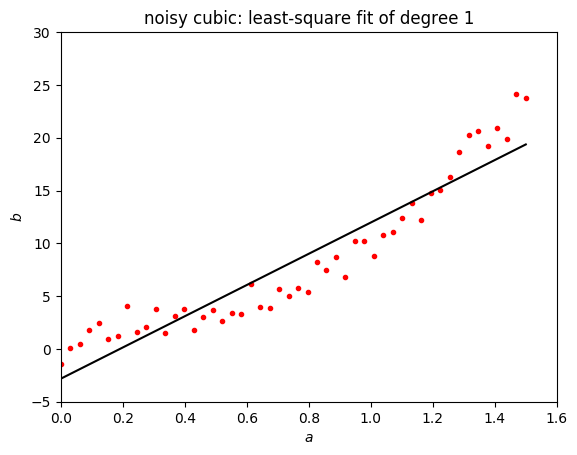

In [9]:
let a = linspace(0,1.5,50),
    afine = linspace(0,1.5,1000),
    b = 1 + 2a + 3a.^2 + 4a.^3 + randn(length(a)),
    fig = figure()
    @manipulate for n=slider(1:40, value=2)
        withfig(fig) do
            plot(a, b, "r.")
            A = a .^ (0:n-1)'
            x̂ = A \ b
            plot(afine, (afine .^ (0:n-1)') * x̂, "k-")
            xlabel(L"a")
            ylabel(L"b")
            xlim(0,1.6)
            ylim(-5,30)
            title("noisy cubic: least-square fit of degree $(n-1)")
        end
    end
end

Increasing the degree of the fit at first seems to improve things, up to about degree 6, but then it becomes more and more wiggly.  It is still reducing the residual, but clearly it is "fitting noise" and the error actually becomes worse compared to the "real" underlying cubic model.  This problem is called [overfitting](https://en.wikipedia.org/wiki/Overfitting).

In between the fitted points, especially near the edges, the wiggles can actually diverge as we increase the degree, an effect related to what is known as a [Runge phenomenon](https://en.wikipedia.org/wiki/Runge's_phenomenon). Even if there is *no noise*, fitting *equally spaced points* to high-degree polynomials can lead to disaster if the underlying data is not exactly polynomial.  Let's demonstrate this by fitting the *smooth* function $b(a) = 1/(1+25a^2)$ to polynomials at 50 points:

Interact.Slider{Int64}(15: "input-6" = 3 Int64 , "", 3, 1:50, "horizontal", true, "d", true)

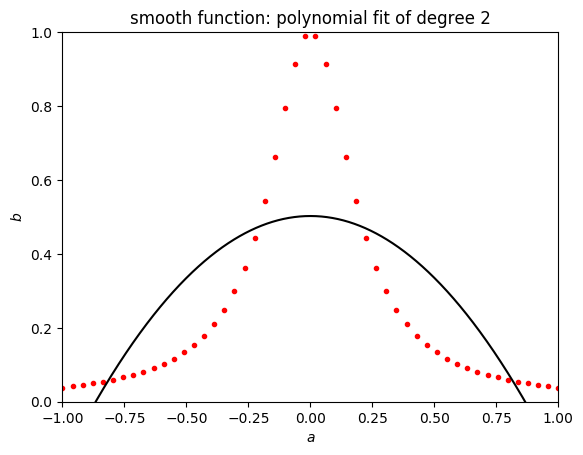

In [10]:
let a = linspace(-1,1,50),
    afine = linspace(-1,1,1000),
    b = 1 ./ (1 + 25 * a.^2),
    fig = figure()
    @manipulate for n=slider(1:50, value=3)
        withfig(fig) do
            plot(a, b, "r.")
            A = a .^ (0:n-1)'
            x̂ = A \ b
            plot(afine, (afine .^ (0:n-1)') * x̂, "k-")
            xlabel(L"a")
            ylabel(L"b")
            xlim(-1,1)
            ylim(0,1)
            title("smooth function: polynomial fit of degree $(n-1)")
        end
    end
end

Be careful not to draw the wrong lesson from this.   You have to be *especially careful* when fitting to high-degree polynomials, but this does *not* mean that you should never do it.

In particular, fitting smooth functions to high-degree polynomials can be a *great* thing to do, as **long as you choose the correct points**.  (Separately, as mentioned above, the construction of the interpolating polynomial should technically not be done by this matrix method once you go to high degrees — you run into roundoff-error problems — but there are better methods like the barycentric formula.)

For example, here we fit the same $1/(1+25a^2)$ function as above to a degree-50 polynomial, with no Runge problems at all, by choosing the points to be [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes) (which cluster together at the edges of the domain):

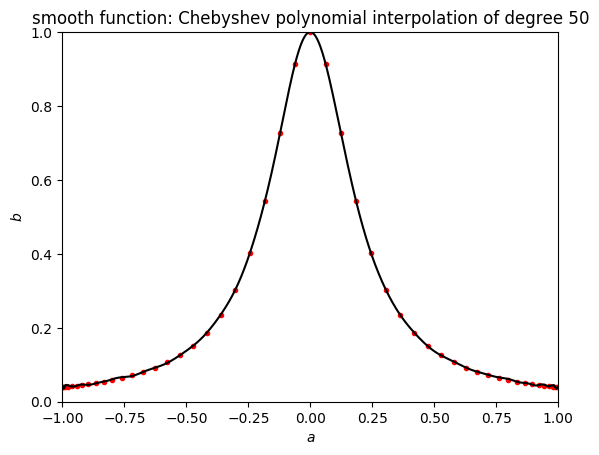

PyObject <matplotlib.text.Text object at 0x133280e90>

In [11]:
n = 51
a = @. cos(((1:n)-0.5) * pi/n) # = Chebyshev nodes of order n
afine = linspace(-1,1,1000)
b = 1 ./ (1 + 25 * a.^2)
plot(a, b, "r.")
A = a .^ (0:n-1)'
x̂ = A \ b
plot(afine, (afine .^ (0:n-1)') * x̂, "k-")
xlabel(L"a")
ylabel(L"b")
xlim(-1,1)
ylim(0,1)
title("smooth function: Chebyshev polynomial interpolation of degree $(n-1)")

How this works goes far outside the bounds of 18.06, but is beautiful and fascinating mathematics.  See, for example, [this book](https://people.maths.ox.ac.uk/trefethen/ATAP/) and [these video lectures](https://people.maths.ox.ac.uk/trefethen/atapvideos.html) by [Nick Trefethen](https://people.maths.ox.ac.uk/trefethen/).

The great thing about fitting complicated functions to polynomials is that polynomials are usually easier to work with — finding roots, derivatives, and integrals of polynomials is easy, for example.   A pioneering software package encapsulating this idea is [chebfun](http://www.chebfun.org/), and a Julia implementation of similar ideas is [ApproxFun](https://github.com/JuliaApproximation/ApproxFun.jl).